In [36]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

X_mnist_train = x_train.reshape((len(x_train), 28, 28, 1))
X_mnist_test = x_test.reshape((len(x_test), 28, 28, 1))

## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [3]:
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
__________

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [47]:
def generate_real_samples(dataset: np.ndarray, n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, dataset.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    random_samples = random_samples.reshape((n_samples, 28, 28, 1))
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [5]:
import matplotlib.pyplot as plt

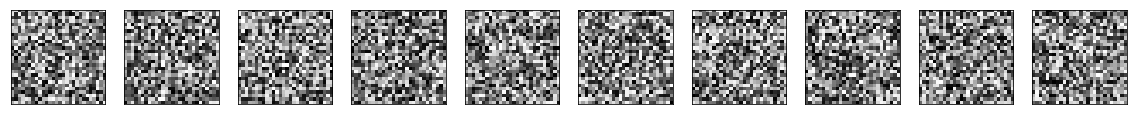

In [6]:
fake_images, _ = generate_fake_samples(10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## About the discriminator
* Since we defined the architecture of the discriminator we are going to train it sequentaly with the whole GAN, not by itself

## Defining a generator

In [7]:
from keras.layers import Reshape, Conv2DTranspose

In [20]:
def generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
    
    return model

In [21]:
generator = generator_model(100)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)       262272    
__________

In [22]:
def generate_latent_points(latent_dim: int, n_samples: int) -> np.ndarray:
    
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [26]:
def generate_fake_generator_samples(generator: Model, latent_dim: int, n_samples: int) -> (np.ndarray, np.ndarray):
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1)) # Zeros because we want to convince the generator that these are fakes
    
    return X, y

### Initial generator examples

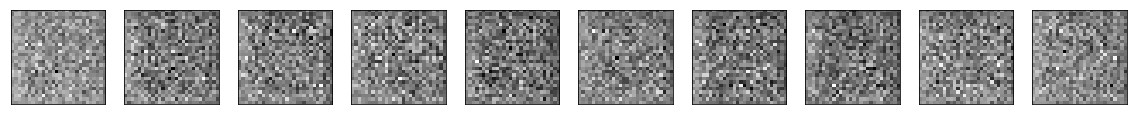

In [27]:
initial_generator_samples, _ = generate_fake_generator_samples(generator, 100, 10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(initial_generator_samples[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Defining a generator

In [28]:
from keras.models import Sequential

In [31]:
def define_gan(g_model: Model, d_model: Model) -> Model:
    
    d_model.trainable = False
    
    model = Sequential()
    
    model.add(g_model)
    
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [32]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 28, 28, 1)         1164289   
_________________________________________________________________
model_1 (Model)              (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Training the GAN model

In [50]:
def test_generator(generator: Model, latent_dim: int, examples: int):
    
    generator_output = generate_fake_generator_samples(generator, latent_dim, examples)
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generator_output[i].reshape((28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [51]:
def train(g_model: Model, d_model: Model, gan_model: Model, dataset: np.ndarray, latent_dim: int, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_generator_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'{i+1}, {j+1}/{batches_per_epoch}, d={d_loss}, g={g_loss}')
        if (i + 1) % 10 == 0:
            test_generator(g_model, latent_dim, 10)

In [52]:
train(generator, discriminator, gan_model, X_mnist_train, 100, 100, 20)

ResourceExhaustedError: OOM when allocating tensor with shape[10,14,14,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_3/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_3/stack, conv2d_transpose_3/kernel/read, reshape_6/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_transpose_3/conv2d_transpose', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-731807bbf200>", line 1, in <module>
    generator = generator_model(100)
  File "<ipython-input-20-c92d14ffdf15>", line 8, in generator_model
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 778, in call
    data_format=self.data_format)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 3388, in conv2d_transpose
    data_format=tf_data_format)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 1257, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 805, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10,14,14,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_transpose_3/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_3/stack, conv2d_transpose_3/kernel/read, reshape_6/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

